# Detecting Tuberculosis in X-Rays

## 📖 Background
Tuberculosis (TB) is one of the most common and deadly respiratory diseases in the world, causing about [1.25 million people in 2023](https://www.who.int/teams/global-programme-on-tuberculosis-and-lung-health/tb-reports/global-tuberculosis-report-2024/tb-disease-burden/1-2-tb-mortality).
Doctors often use chest X-rays to help detect TB. However, looking at many X-rays by hand can be slow and difficult.

In this challenge, you will build a simple machine learning model that can help classify chest X-ray images into two groups:

- Healthy lungs
- Lungs affected by TB

This is not about building a “perfect” model. The focus should be on how you describe your process, decisions, and learnings.



## 🩻 The Data

<img src="x-rays_sample.png" align="center"/>
&nbsp

You are given a small dataset from the Sakha-TB dataset:

- Training data: 150 healthy + 150 TB images (300 total)
- Test data: 50 healthy + 50 TB images (100 total)

These images are in the **data.zip** file at the root of the notebook. They will then be in the `data/chestxray` folder, which is further divided into `test` and `train`, both containing `healthy` and `tb` folders with the images inside.

## 💪 Challenge


You will train a model to classify chest X-rays. Your report should cover these questions:

1. **Preprocessing**  
   What steps did you take to make the images easier for a model to understand?  
   Some ideas to think about:  
   - Did you resize the images to the same size?  
   - Did you convert them to grayscale or normalize the pixel values?  
   - Did you try any simple image transformations (e.g., small rotations)?  

2. **Modeling**  
   Try at least **two models** and compare them.  
   - One can be a simple model you build yourself (like a small CNN).  
   - Another can be a pre-trained model (like ResNet or MobileNet).  
   Explain what you tried and what differences you observed.  

3. **Evaluation**  
   Evaluate your models on the test set. Report the following metrics in plain words:  
   - **Sensitivity (Recall for TB):** How many TB cases your model correctly finds.  
   - **Specificity:** How many healthy cases your model correctly identifies.  
   - **Positive Predictive Value (PPV):** When your model says “TB”, how often it’s right.  
   - **Negative Predictive Value (NPV):** When your model says “Healthy”, how often it’s right.  

   👉 *Tip: You don’t need to get the “best” numbers. Focus on explaining what the metrics mean and what you learned.*  

4. **[Optional] ROC Curve**  
   If you want, you can also draw a Receiver Operating Characteristic (ROC) curve to visualize how your model performance changes with different thresholds.


## ✅ Checklist before publishing
- Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
- **Remove redundant cells** like the introduction to data science notebooks, so the workbook is focused on your story.
- Check that all the cells run without error.

## ⌛️ Time is ticking. Good luck!

### **Import Library**

In [1]:
from PIL import Image, ImageFile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
import cv2
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import matplotlib.pyplot as plt
import io
import os

### **Load Data**

In [2]:
import zipfile

# Unzip the data folder
if not os.path.exists('data/chestxrays'):
    with zipfile.ZipFile('data.zip', 'r') as zip_ref:
        zip_ref.extractall()

In [2]:
def load_images(directory):
    images=[]
    for filename in os.listdir(directory):

        img = Image.open(os.path.join(directory, filename))
        img = img.resize((224, 224))
        img = img.convert('RGB')
        img = np.array(img) / 255.0
        images.append(img)
    return images

In [3]:
tb_image = load_images('data/chestxrays/tb')
health_image = load_images('data/chestxrays/healthy')

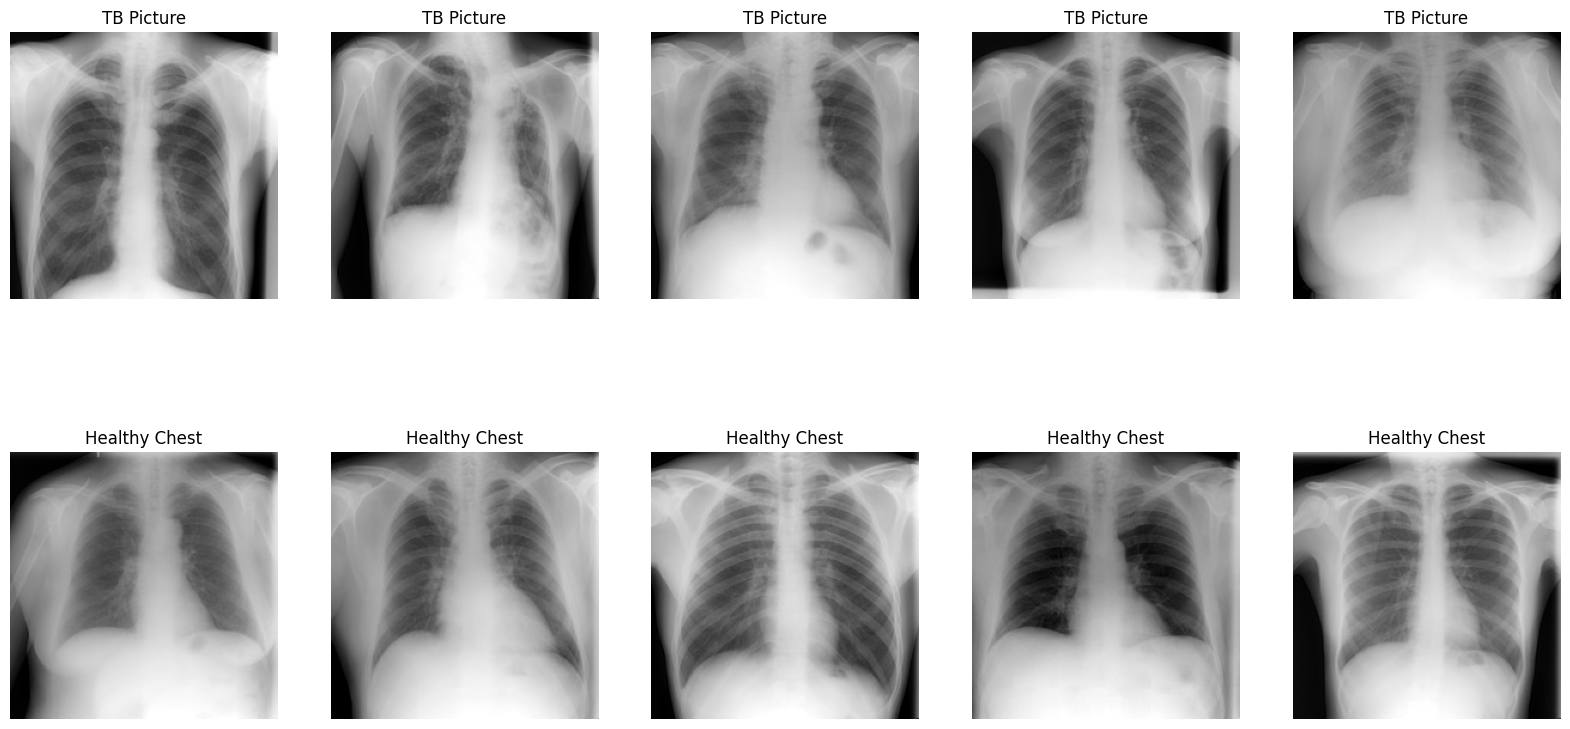

In [4]:
#Showe images
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i in range(5):
    axes[0, i].imshow(tb_image[i])
    axes[0, i].set_title('TB Picture')
    axes[0, i].axis('off')

for i in range(5):
    axes[1, i].imshow(health_image[i])
    axes[1, i].set_title('Healthy Chest')
    axes[1, i].axis('off')

plt.show()

In [5]:
print(type(tb_image))

<class 'list'>


In [6]:
print(len(tb_image))
print(len(health_image))

201
201


In [7]:
tb_image

[array([[[0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098],
         ...,
         [0.69411765, 0.69411765, 0.69411765],
         [0.70588235, 0.70588235, 0.70588235],
         [0.69803922, 0.69803922, 0.69803922]],
 
        [[0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098],
         ...,
         [0.69019608, 0.69019608, 0.69019608],
         [0.69803922, 0.69803922, 0.69803922],
         [0.69411765, 0.69411765, 0.69411765]],
 
        [[0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098],
         ...,
         [0.67843137, 0.67843137, 0.67843137],
         [0.69411765, 0.69411765, 0.69411765],
         [0.68627451, 0.68627451, 0.68627451]],
 
        ...,
 
        [[0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745

### **Labeling**

In [8]:
def assign_labels(tb_image, health_image):
    tb_labels = np.ones(len(tb_image))
    health_labels = np.zeros(len(health_image))
    return tb_labels, health_labels
tb_labels, health_labels = assign_labels(tb_image, health_image)

In [9]:
print(tb_labels)
print(health_labels)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 

In [10]:
print(type(tb_labels))
print(type(health_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [11]:
#Create data variabels
data = tb_image + health_image
labels = np.concatenate((tb_labels, health_labels), axis=0)

In [12]:
print(data)
print(labels)

[array([[[0.02745098, 0.02745098, 0.02745098],
        [0.02745098, 0.02745098, 0.02745098],
        [0.02745098, 0.02745098, 0.02745098],
        ...,
        [0.69411765, 0.69411765, 0.69411765],
        [0.70588235, 0.70588235, 0.70588235],
        [0.69803922, 0.69803922, 0.69803922]],

       [[0.02745098, 0.02745098, 0.02745098],
        [0.02745098, 0.02745098, 0.02745098],
        [0.02745098, 0.02745098, 0.02745098],
        ...,
        [0.69019608, 0.69019608, 0.69019608],
        [0.69803922, 0.69803922, 0.69803922],
        [0.69411765, 0.69411765, 0.69411765]],

       [[0.02745098, 0.02745098, 0.02745098],
        [0.02745098, 0.02745098, 0.02745098],
        [0.02745098, 0.02745098, 0.02745098],
        ...,
        [0.67843137, 0.67843137, 0.67843137],
        [0.69411765, 0.69411765, 0.69411765],
        [0.68627451, 0.68627451, 0.68627451]],

       ...,

       [[0.02745098, 0.02745098, 0.02745098],
        [0.02745098, 0.02745098, 0.02745098],
        [0.03137255, 

In [13]:
print(data[0].shape)
print(labels[0].shape)

(224, 224, 3)
()


### **Splitting Data**

In [14]:
X = np.array(data)
y = np.array(labels)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

In [16]:
#Create dataset use tenserflow
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

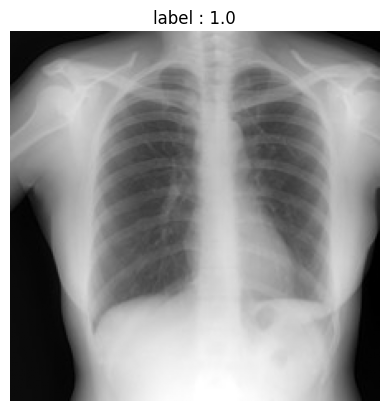

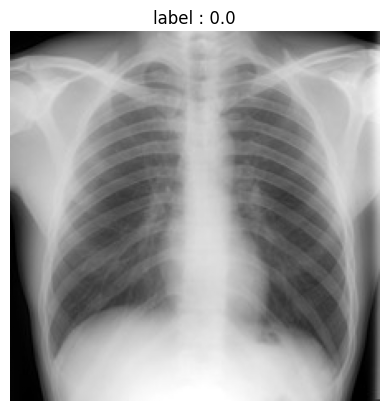

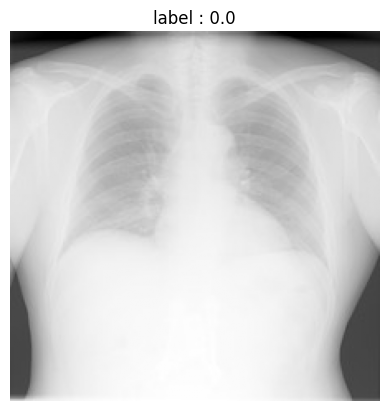

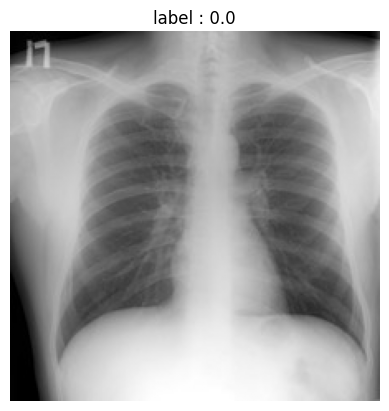

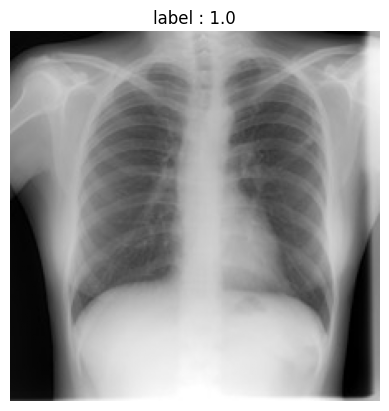

In [17]:
#Display train image 
for image, label in train.take(5):
    plt.figure()
    plt.imshow(image.numpy())
    plt.title('label : {}'.format(label.numpy()))
    plt.axis('off')
    plt.show()

In [18]:
#Create validation
val_size = int(0.1 * 202)
train = train.skip(val_size)
val = train.take(val_size)

In [19]:
batch_size = 32
train = train.batch(batch_size)
test = test.batch(batch_size)
val = val.batch(batch_size)

### **Training Data**

In [20]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='valid'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

C:\Users\user\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │   100,933,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,935,041 (385.04 MB)

 Trainable params: 100,935,041 (385.04 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
history = model.fit(train, validation_data = val, epochs=10, verbose= 1)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4917 - loss: 33.1636 - val_accuracy: 0.4500 - val_loss: 15.6782
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5449 - loss: 10.0702 - val_accuracy: 0.4500 - val_loss: 4.4568
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5515 - loss: 3.4407 - val_accuracy: 0.8000 - val_loss: 0.5447
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6611 - loss: 0.8447 - val_accuracy: 0.8500 - val_loss: 0.4533
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7176 - loss: 0.5749 - val_accuracy: 0.8500 - val_loss: 0.4556
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7575 - loss: 0.5319 - val_accuracy: 0.9000 - val_loss: 0.3895
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7641 - loss: 0.5038 - val_accuracy: 0.8500 - val_loss: 0.3409
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7874 - loss: 0.4755 - val_accuracy: 0.9000 - val_lo

In [24]:
evaluation = model.evaluate(test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.6914 - loss: 0.6323


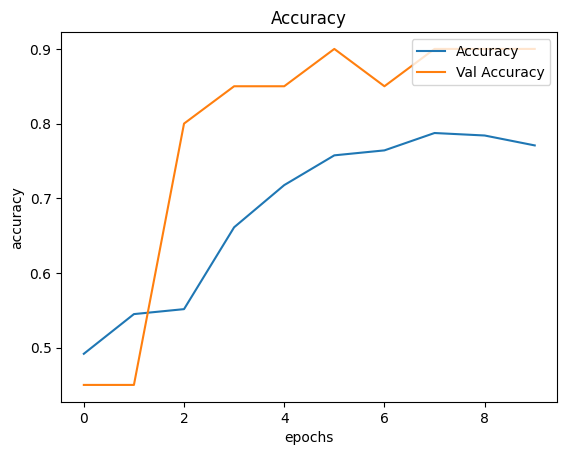

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy', 'Val Accuracy'], loc = 'upper right')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

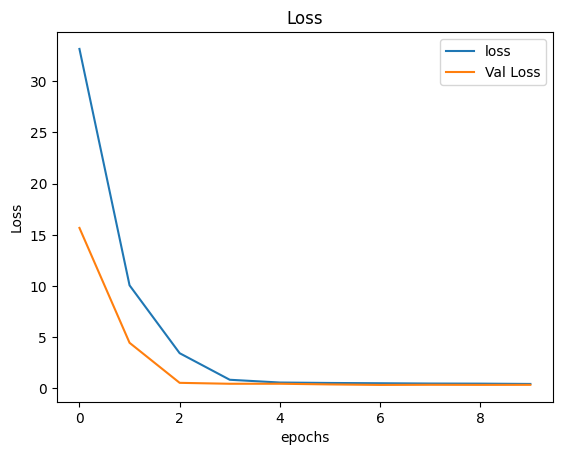

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'Val Loss'], loc = 'upper right')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

### **Testing**

In [34]:
def load_upload_image(image_bytes):
    img = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = img_array / 255.0
    return img_array

def predict_image(image_bytes):
    img_array = load_upload_image(image_bytes)
    img_array = np.expand_dims(img_array, axis =0)
    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        return "TB detected"
    else:
        return "Health chest"

In [35]:
#Tested by image
from ipywidgets import FileUpload
from IPython.display import display

uploaded = FileUpload(accept='image/*', multiple=False)
display(uploaded)


FileUpload(value=(), accept='image/*', description='Upload')

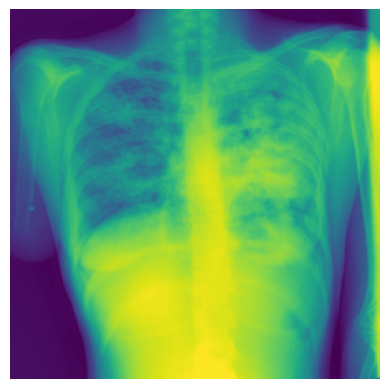

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
TB detected


In [36]:
file_name = uploaded.value[0]
image_bytes = file_name['content']
img = Image.open(io.BytesIO(image_bytes))

plt.imshow(img)
plt.axis('off')
plt.show()

result = predict_image(image_bytes)
print(result)

### **Compare with another model**

In [38]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    input_shape =(224, 224, 3),
    include_top=False,
    weights = "imagenet"
)

base_model.trainable = False

model_mo = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model_mo.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics =["accuracy"]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 9s 1us/step


In [40]:
hist = model_mo.fit(train, validation_data = val, epochs=10, verbose= 1)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 703ms/step - accuracy: 0.5615 - loss: 0.7562 - val_accuracy: 0.9000 - val_loss: 0.3309
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 669ms/step - accuracy: 0.7076 - loss: 0.5468 - val_accuracy: 0.9500 - val_loss: 0.2978
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 665ms/step - accuracy: 0.7508 - loss: 0.5014 - val_accuracy: 0.8000 - val_loss: 0.3306
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 650ms/step - accuracy: 0.7542 - loss: 0.5079 - val_accuracy: 0.8500 - val_loss: 0.3161
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 638ms/step - accuracy: 0.7575 - loss: 0.4701 - val_accuracy: 0.9500 - val_loss: 0.2031
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 642ms/step - accuracy: 0.8206 - loss: 0.4075 - val_accuracy: 1.0000 - val_loss: 0.1731
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 644ms/step - accuracy: 0.8206 - loss: 0.3780 - val_accuracy: 0.9000 - val_loss: 0.1921
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 636ms/step - accuracy: 0.8206 - loss: 0.3949 - val_accuracy: 0

In [41]:
model_mo.evaluate(test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 482ms/step - accuracy: 0.7284 - loss: 0.5084


[0.5083589553833008, 0.7283950448036194]

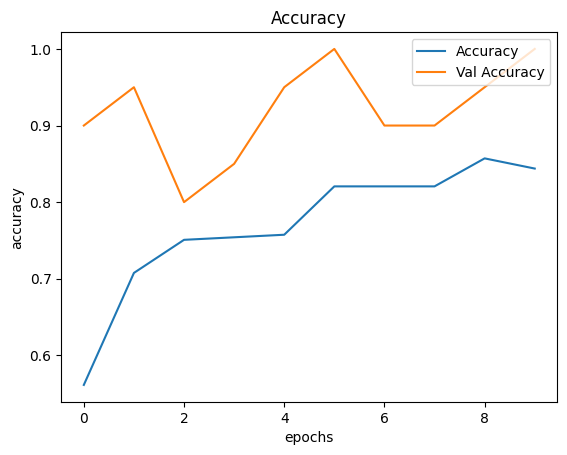

In [42]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['Accuracy', 'Val Accuracy'], loc = 'upper right')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

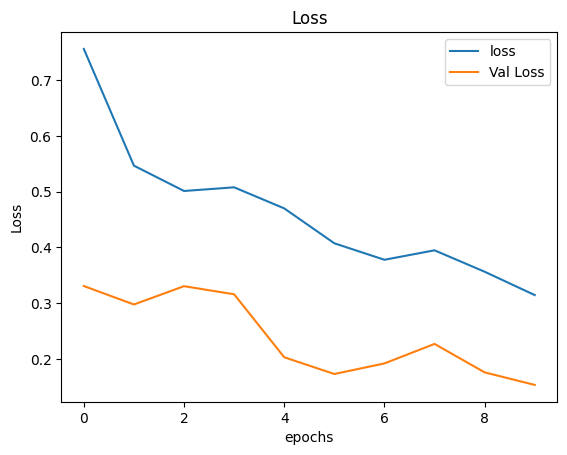

In [43]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'Val Loss'], loc = 'upper right')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

### **Testing use MobileNet2D**

In [48]:
def load_upload_img(image_bytes):
    img = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    img = img.resize((224, 224))
    image_array = np.array(img)
    image_array = image_array / 255.0
    return image_array

def predict_img(img_bytes):
    image_array = load_upload_img(img_bytes)
    image_array = np.expand_dims(image_array, axis =0)
    prediction = model_mo.predict(image_array)
    if prediction[0][0] > 0.5:
        return "TB detected"
    else:
        return "Health chest"

In [49]:
#Tested by image
uploader = FileUpload(accept='image/*', multiple=False)
display(uploader)

FileUpload(value=(), accept='image/*', description='Upload')

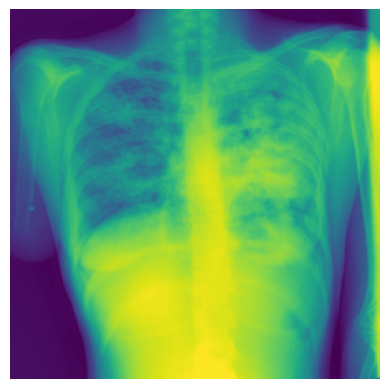

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Health chest


In [50]:
upload_file = uploader.value[0]
img_bytes = upload_file['content']
image = Image.open(io.BytesIO(img_bytes))

plt.imshow(img)
plt.axis('off')
plt.show()

result_ = predict_img(img_bytes)
print(result_)

The first model shows early signs of overfitting, as the training accuracy continues to increase while the validation accuracy starts to fluctuate after several epochs. In contrast, the second model based on MobileNet does not exhibit overfitting and demonstrates better generalization performance.

### **Metrics**

1. CNN Model

In [56]:
#Class prediction (default threshold 0.5)
y_pred_c = model.predict(X_test)
y_pred_c = (y_pred_c > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


In [57]:
from sklearn.metrics import confusion_matrix

#Model evaluation
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_c).ravel()

print("Confussion Matrix:\n")
print("TP:", tp)
print("FN:", fn)
print("FP:", fp)
print("TN:", tn)

Confussion Matrix:

TP: 28
FN: 17
FP: 8
TN: 28


In [59]:
def safe_div(a, b):
    return a / b if b != 0 else 0

sensitivity = safe_div(tp, tp + fn)
specificity = safe_div(tn, tn + fp)
ppv = safe_div(tp, tp + fp)
npv = safe_div(tn, tn + fn)

print(f"Sensitivity (Recall TB): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"PPV: {ppv:.3f}")
print(f"NPV: {npv:.3f}")

Sensitivity (Recall TB): 0.622
Specificity: 0.778
PPV: 0.778
NPV: 0.622


In [60]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_c, target_names=["Healthy", "TB"]))

              precision    recall  f1-score   support

     Healthy       0.62      0.78      0.69        36
          TB       0.78      0.62      0.69        45

    accuracy                           0.69        81
   macro avg       0.70      0.70      0.69        81
weighted avg       0.71      0.69      0.69        81



Based on the confusion matrix of the CNN model, there are 17 false negative cases, where patients who actually have TB are incorrectly classified as healthy. This is dangerous because these patients may not receive proper treatment and can easily spread the disease to others.

In addition, there are 8 false positive cases, where healthy patients are incorrectly classified as having TB. This situation should also be considered carefully, as these patients may undergo unnecessary medical examinations or treatments.

2. MobileNet2D Model

In [61]:
#Class prediction (default threshold 0.5)
y_pred_m = model_mo.predict(X_test)
y_pred_m = (y_pred_m > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step


In [63]:
#Model evaluation
tn_m, fp_m, fn_m, tp_m = confusion_matrix(y_test, y_pred_m).ravel()

print("Confussion Matrix:\n")
print("TP:", tp_m)
print("FN:", fn_m)
print("FP:", fp_m)
print("TN:", tn_m)

Confussion Matrix:

TP: 36
FN: 9
FP: 13
TN: 23


In [64]:
def safe_div_m(a, b):
    return a / b if b != 0 else 0

sensitivity_m = safe_div_m(tp, tp + fn)
specificity_m = safe_div_m(tn, tn + fp)
ppv_m = safe_div_m(tp, tp + fp)
npv_m = safe_div_m(tn, tn + fn)

print(f"Sensitivity (Recall TB): {sensitivity_m:.3f}")
print(f"Specificity: {specificity_m:.3f}")
print(f"PPV: {ppv_m:.3f}")
print(f"NPV: {npv_m:.3f}")

Sensitivity (Recall TB): 0.800
Specificity: 0.639
PPV: 0.735
NPV: 0.719


In [66]:
print(classification_report(y_test, y_pred_m, target_names=["Healthy", "TB"]))

              precision    recall  f1-score   support

     Healthy       0.72      0.64      0.68        36
          TB       0.73      0.80      0.77        45

    accuracy                           0.73        81
   macro avg       0.73      0.72      0.72        81
weighted avg       0.73      0.73      0.73        81



Based on the confusion matrix of the MobileNet2D model, there are 9 false negative cases, where patients who actually have TB are incorrectly classified as healthy. This is dangerous because these patients may not receive proper treatment and can easily spread the disease to others.

In addition, there are 13 false positive cases, where healthy patients are incorrectly classified as having TB. This should also be taken into consideration, as these patients may undergo unnecessary medical examinations or treatments.

These two models show opposite error patterns compared to each other

### **ROC-Curve**

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step
AUC Model 1 (CNN): 0.741358024691358
AUC Model 2 (MobileNet): 0.8043209876543209


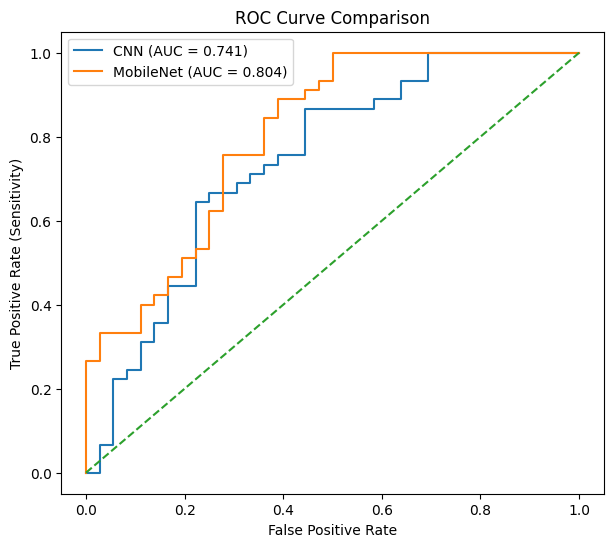

In [65]:
from sklearn.metrics import roc_curve, auc

# Prediksi probabilitas
y_prob_c = model.predict(X_test).ravel()
y_prob_m = model_mo.predict(X_test).ravel()

# ROC model 1
fpr1, tpr1, _ = roc_curve(y_test, y_prob_c)
auc1 = auc(fpr1, tpr1)

# ROC model 2
fpr2, tpr2, _ = roc_curve(y_test, y_prob_m)
auc2 = auc(fpr2, tpr2)

print("AUC Model 1 (CNN):", auc1)
print("AUC Model 2 (MobileNet):", auc2)

# Plot
plt.figure(figsize=(7,6))
plt.plot(fpr1, tpr1, label=f"CNN (AUC = {auc1:.3f})")
plt.plot(fpr2, tpr2, label=f"MobileNet (AUC = {auc2:.3f})")
plt.plot([0,1], [0,1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

The ROC curves indicate that both models perform well in distinguishing between TB and healthy cases. The curves rise toward the upper-left corner of the plot, and both models achieve AUC values close to 1, indicating strong classification performance.

In [68]:
model_mo.save('tb_detect_mo.keras')